# Untitled Supermarked Project
## Queuing Simulator
This Queuing Simulator can be used to simulate a wide variety of  situations and is therefore quite flexible. It's structure however, is heavily tailored to the needs of the dataset.<br>
This notebook visualizes the uses of the function. For the main Jupyter Notebook, a .py file is used to import the functions.

### Setting Up Workshop

In [476]:
# DataFrames
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
# Statistics
from scipy import stats 
# Array and Array Math
import numpy as np

### Simulating a Queuing System
<img src="https://upload.wikimedia.org/wikipedia/commons/6/65/Mm1_queue.svg"/>
In queuing theory a basic queuing system consists of customers an arrival process, service station (which follow a service process) and the resulting queue. The waiting is the result of an arrival while the station is busy serving a customer.<br>
The entry-process is a stochastic process, meaning that the time between each arrival is determined by a random variable. The service-process determines similary the time needed to service a customer. After the service, the customer leaves the system.
There can be more than one station:
<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Queueing_node_service_digram.png"/>
Therefore, in order to set up a basic queuing system, one needs to determine:<br>
- the entry process,<br>
- the service process, and<br>
- the number of stations.

#### Python Functions
<u>Entry Process:</u> Determined by random variable via a scipy.stats object (entry_variable) and its parameters (entry_variable_parameters).<br>
<u>Service Process:</u> Is determined by a random variable and parameters (service_variable, service_variable_paramenter).<br>
<u>Number of Stations:</u> Is derived from "shifts", in order to process the information from the dataset directly. Shifts will be a list of tupels, comprising of the beginning and the end of the shift. Examples:<br>
- One Station: [(0,np.nan)], meaning a shift that starts at 0 and ends at the end of the run.<br>
- Two Stations: [(0,np.nan),(0,np.nan)].<br>

In [477]:
# Random generates an Entry-Process (= "the time a customer enters the waiting area")
def entry_process(customers, entry_variable, entry_variable_parameters):
    # Set up Collector for results
    results          = pd.DataFrame([])
    # Generates randomly how much time passes between Customers
    results["time"]  = entry_variable(** entry_variable_parameters, size = customers)
    # Sum up to determine entry time of each customer
    results["entry"] = results.time.cumsum()
    # Return results
    return results["entry"]

In [478]:
demo_arrival = entry_process(customers                 = 5,
                             entry_variable            = stats.expon.rvs,
                             entry_variable_parameters = {"loc" : 0, "scale" : 1/1, "random_state" : 0})
print(demo_arrival)

0    0.795875
1    2.051805
2    2.975028
3    3.762230
4    4.313278
Name: entry, dtype: float64


In [479]:
# Random-generates the the service-process and the resulting exit-process
# (= "the time a customer gets to/ leaves the cashier")
def service_process(entries, service_variable, service_variable_parameters, shifts):
    # Turn Shifts into Stations
    stations = np.array(shifts, dtype=[('ready', '<f8'), ('close', '<f8')])
    # Set up Collectors for Results
    results_service = ([])
    results_station = ([])
    results_exit    = ([]) 
    # Cycle through Customers of the Entry-Process
    for idx in entries:      
        # Index of next available Station
        # (Customer chooses Station which has been unoccupied the longest)
        free = np.nanmin(np.argwhere(stations["ready"] == np.nanmin(stations["ready"])))
        # Add Time when Customer starts being serviced 
        results_service.append(max(idx,stations["ready"][free])) 
        # Generate time when Customer is done
        done = float(max(idx,stations["ready"][free]) + service_variable(** service_variable_parameters, size = 1))
        # Add Time when Customer is done/ leaves the register
        results_exit.append(done)
        # Add used Station
        results_station.append(free)
        # Check if shift is over and Station can be closed
        if(stations["close"][free] <= done):
            # Close Station
            stations["ready"][free] = np.nan
        else:
            # Update Station's Ready Time
            stations["ready"][free] = done   
    # Return results
    return results_service, results_exit, results_station

In [480]:
service_process(entries                     = demo_arrival,
                service_variable            = stats.expon.rvs,
                service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 1},
                shifts                      = [(0,np.nan),(0,np.nan)])

([0.79587450816311,
  2.0518052711289476,
  2.9750284169330166,
  3.7622295692502874,
  4.3132780603457865],
 [1.3354803454222954,
  2.591411108388133,
  3.514634254192202,
  4.301835406509473,
  4.852883897604972],
 [0, 1, 0, 1, 0])

In [481]:
# Simulate Queue by combining entry_process and service_process, and returning the relevant data in a dataframe
def makeq(n_customers,
          entry_variable,entry_variable_parameters,
          service_variable,service_variable_parameters,
          shifts,
          exitsort = True):
    # Set Up Collector for Results
    overview                              = pd.DataFrame([])
    # Random Generate Entrance of Customers
    overview["entry"]                     = entry_process(n_customers,
                                                          entry_variable,
                                                          entry_variable_parameters)
    # Random Generate Service/ Exit of Customers
    overview["service"], overview["exit"], overview["station"] = service_process(overview["entry"], 
                                                                                 service_variable,
                                                                                 service_variable_parameters, 
                                                                                 shifts)
    # If chosen, sort by Exit-Time
    if exitsort:
        overview.sort_values(by=["exit"], inplace = True)
        overview.reset_index(inplace = True)        
    # Return resulting Dataframe
    return(overview)

In [482]:
makeq(n_customers                 = 5,
      entry_variable              = stats.expon.rvs,
      entry_variable_parameters   = {"loc" : 0, "scale" : 1/1, "random_state" : 0},
      service_variable            = stats.expon.rvs,
      service_variable_parameters = {"loc" : 0, "scale" : 1/1, "random_state" : 1},
      shifts                      = [(0,np.nan),(0,np.nan)])

,index,entry,service,exit,station
0,0,0.795875,0.795875,1.335480,0
1,1,2.051805,2.051805,2.591411,1
2,2,2.975028,2.975028,3.514634,0
3,3,3.762230,3.762230,4.301835,1
4,4,4.313278,4.313278,4.852884,0


#### Test Runs
The test runs will be named using the Kendall Notation: Entry Process/ Service Process/ Number of Stations.<br>
<i>M</i> means the time between arrivals is exponential-random distributed. $ \lambda $ is the arrival rate, $ \mu $ the service rate. You can find explanations on the Kendall Notation [here](https://en.wikipedia.org/wiki/Kendall%27s_notation).

##### M/M/1 Queue
- $ \lambda $ : 1
- $ \mu $ : 1

In [483]:
title                       = "M/M/1 - Queue"
q_lambda                    = 1
q_my                        = 1
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1/q_lambda, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1/q_my, "random_state" : 0}
shifts                      = [(0,np.nan)]

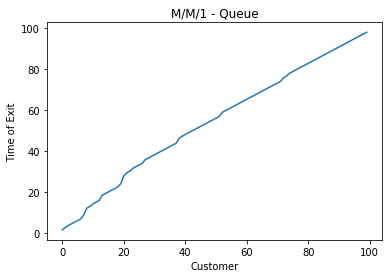

In [484]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable,   entry_variable_parameters,
                service_variable, service_variable_parameters,
                shifts)
# Plot Results
plt.title(title)
plt.plot(example.exit)
plt.ylabel("Time of Exit")
plt.xlabel("Customer")
plt.show()

#### M/M/2 Queue
- $ \lambda $ : 1
- $ \mu $ : 1

In [485]:
title                       = "M/M/2 - Queue"
q_lambda                    = 1
q_my                        = 1
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1/q_lambda, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1/q_my, "random_state" : 0}
shifts                      = [(0,np.nan),(0,np.nan)]

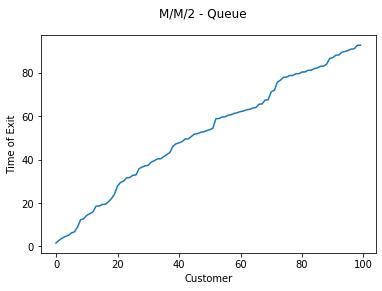

In [486]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                shifts)
# Plot Results
plt.suptitle(title)
plt.plot(example.exit)
plt.ylabel("Time of Exit")
plt.xlabel("Customer")
plt.show()

#### M/M/c(t) Queue
- $ \lambda $ : 2
- $ \mu $ : 1
- <b>c(t)</b> : 1 for t <= 20 and t >= 40, 2 for t > 20 and t < 40

In [487]:
title                       = "M/M/c(t) - Queue"
q_lambda                    = 2
q_my                        = 1
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1/q_lambda, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1/q_my, "random_state" : 0}
shifts                      = [(0,np.nan),(20,40)]

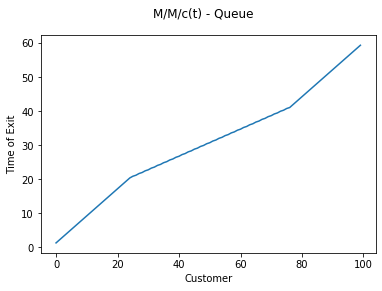

In [488]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                shifts)
# Plot Results
plt.suptitle(title)
plt.plot(example.exit)
plt.ylabel("Time of Exit")
plt.xlabel("Customer")
plt.show()

### Monte Carlo Studies 

#### Functions

In [489]:
# Make a set, which stores the relevant results (exit time of each costumer) from multiple queuing simulation runs
def alotta_queues (runs,
                 n_customers, entry_variable, entry_variable_parameters,
                 service_variable, service_variable_parameters, shifts):
    # Set up Collector for results
    exits = pd.DataFrame([])
    # Runs multiple Queing Simulations
    for idx in range(1,runs+1):    
        exits = exits.append(makeq(n_customers, entry_variable, entry_variable_parameters,
                                  service_variable, service_variable_parameters, shifts).exit)
    exits.index = range(0,runs)
    exits = exits.T
    return exits

In [490]:
# Visualize the Runs of the Queuing Simulations
def show_mcq (qspace, title, breakoff):
    # Extract necessary Information
    runs        = qspace.shape[1]
    n_customers = qspace.shape[0]   
    # Process Data for Visualization
    qspace_max = qspace.max(axis = 1)
    qspace_q99 = qspace.quantile(.99, axis = 1)
    qspace_q75 = qspace.quantile(.75, axis = 1)
    qspace_med = qspace.median(axis = 1)
    qspace_q25 = qspace.quantile(.25, axis = 1)
    qspace_q01 = qspace.quantile(.01, axis = 1)
    qspace_min = qspace.min(axis = 1)
    # Visualize Results
    plt.suptitle(title)
    plt.title(str(runs)+" runs")
    plt.fill_between(x = range(0,n_customers), y1 = qspace_max, y2 = qspace_min, color = "#DDEEDD")
    plt.fill_between(x = range(0,n_customers), y1 = qspace_q99, y2 = qspace_q01, color = "#BBCCBB")
    plt.fill_between(x = range(0,n_customers), y1 = qspace_q75, y2 = qspace_q25, color = "#99AA99")
    plt.plot(qspace_med, color = "green")
    plt.ylabel("Time of Exit")
    plt.xlabel("Customer")
    plt.legend(['Median',"Minimum to Maximum",'Quantile .01 to .99','Quantile .25 to .75'], loc = 2)
    # If chosen, the graph can be closed of for additions
    if breakoff:
        plt.show()

In [491]:
# Compare a certain case to model-based generated data
def compare(qspace, case, visualize):
    # Visualize if Chosen
    if visualize:
        # Visualize Queing System
        show_mcq(qspace, title, False)
        # Visualize given Case
        plt.plot(case.exit, color = 'red')
        plt.show()
        # Show Case
        plt.title("Absolute Distance from Median")
        plt.ylabel("Absolute Distance")
        plt.plot(abs(qspace.median(axis = 1) - case.exit), color = "red")
        # Visualize Mean
        plt.hlines(abs(qspace.median(axis = 1) - case.exit).mean(), xmin = 0, xmax = case.shape[0], color = "orange")
        plt.legend(['Absolute Distance','Mean over Time'])
        plt.show()
    # Return Mean Square Error
    return abs(qspace.median(axis = 1) - case.exit).mean()

#### Test Run - MCSim

In [492]:
runs                        = 1000
title                       = "M/M/c(t) - Queue"
q_lambda                    = 2
q_my                        = 1
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1/q_lambda}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1/q_my}
shifts                      = [(0,np.nan),(20,40)]

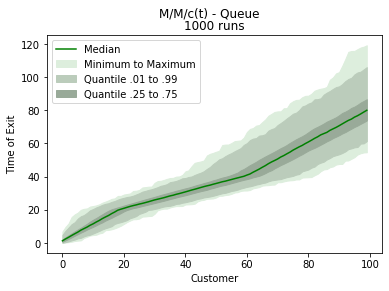

In [493]:
# Generate Data
example_qspace = alotta_queues(runs,
                               n_customers,
                               entry_variable, entry_variable_parameters,
                               service_variable, service_variable_parameters,
                               shifts)
# Visualize Result
show_mcq(example_qspace, title, True)

#### Test Runs - Case Evaluation

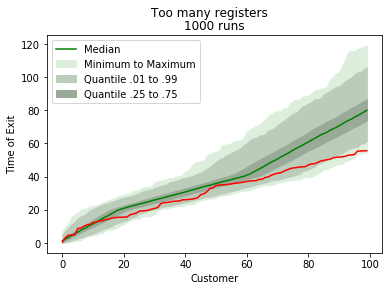

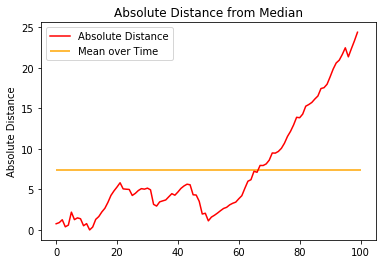

7.380951183441841

In [494]:
# Generate Data
title       = "Too many registers"
mistake_tmr = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                shifts = [(0,np.nan),(0,np.nan)])
# Compares
compare(example_qspace, mistake_tmr, True)

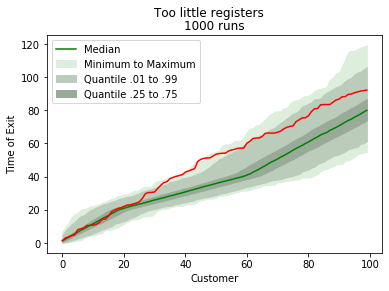

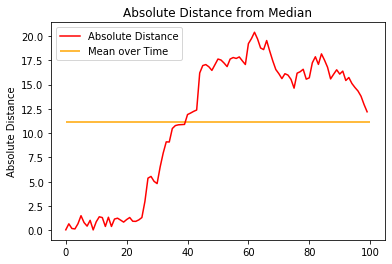

11.183568739017437

In [495]:
# Generate Data
title       = "Too little registers"
mistake_tlr = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                shifts = [(0,np.nan)])
# Compares
compare(example_qspace, mistake_tlr, True)

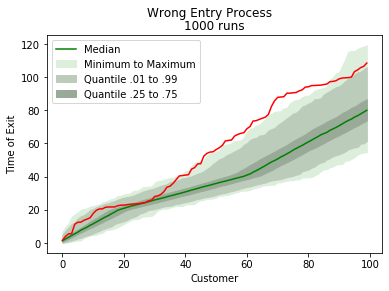

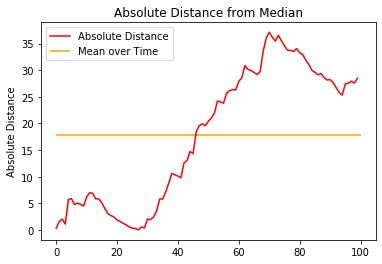

17.769110382722438

In [496]:
# Generate Data
title       = "Wrong Entry Process"
mistake_wep = makeq(n_customers,
                    entry_variable, {"loc" : 0, "scale" : 1/1},
                    service_variable, service_variable_parameters,
                    shifts)
# Compares
compare(example_qspace, mistake_wep, True)

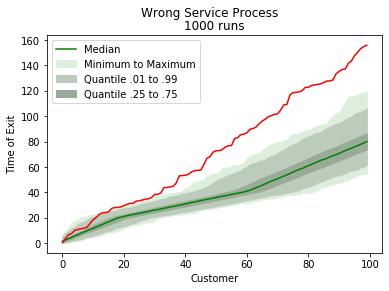

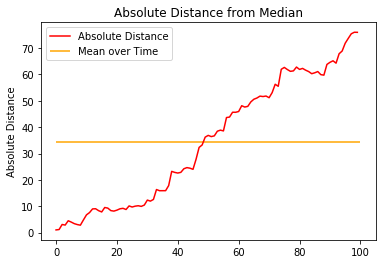

34.51643895237798

In [497]:
# Generate Data
title       = "Wrong Service Process"
mistake_wsp = makeq(n_customers,
                    entry_variable, entry_variable_parameters,
                    service_variable, {"loc" : 0, "scale" : 1/.5},
                    shifts)
# Compares
compare(example_qspace, mistake_wsp, True)

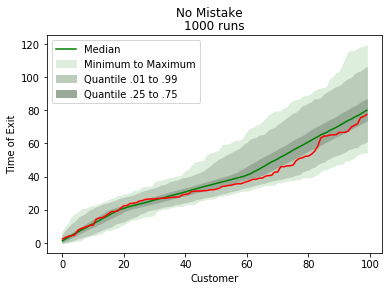

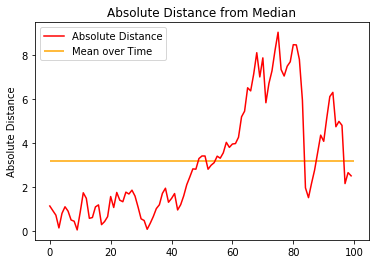

3.1851834468483458

In [498]:
# Generate Data
title       = "No Mistake"
mistake_non= makeq(n_customers,
                    entry_variable, entry_variable_parameters,
                    service_variable, service_variable_parameters,
                    shifts)
# Compares
compare(example_qspace, mistake_non, True)

## Sorces
- Images: Wikipedia

## Future Works
### Queue Generator:
- Non Stationary Entry-Process<br>
- Non Stationary Service-Process<br>
- Offer Choice to end QueueSim after specific time passed vs specific number of customers<br>
- Multiplot for Analysis (EntryTime/ Exit Time; EntryTime/ Waiting Time; Customer/ Exittime)<br>

### Monte Carlo Simulation:
- ! Implement different scoring method (f.e. something quantile based) !<br>
- Write short explanation of procedure<br>
- Validate Queue Generator<br>
- Animated Visualizations (http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/)<br>
- Select Number of runs vs desired accuracy of results<br>

### General
- Export Functions to .py<br>
- Consider List vs Numpy vs Pandas<br>
- Consider Object-Oriented approach<br>